In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [2]:
IMAGE_SIZE = [224, 224]


epochs = 500
batch_size = 32


covid_path = r'C:\Users\Arghyadeep\Downloads\data and models\data\chest\Chest_COVID'
noncovid_path = r'C:\Users\Arghyadeep\Downloads\data and models\data\chest\Chest_NonCOVID'


covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [3]:
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

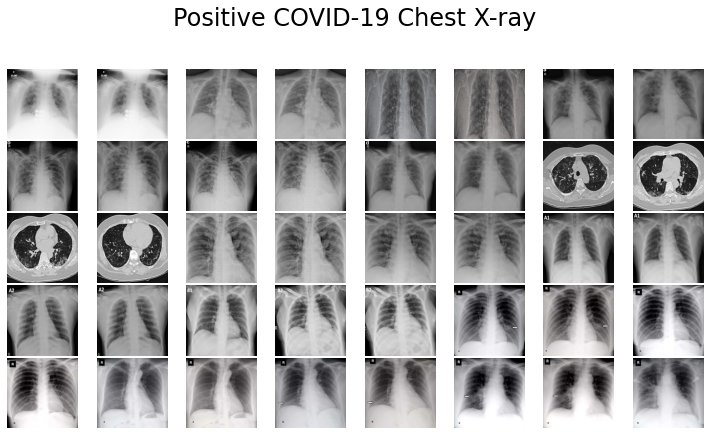

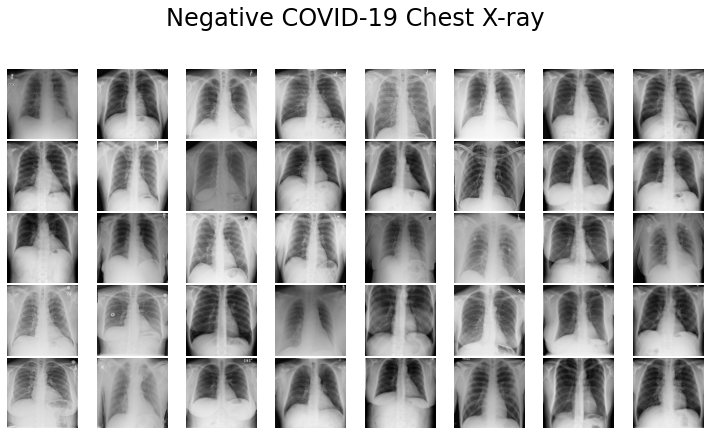

In [4]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [5]:
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)


y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

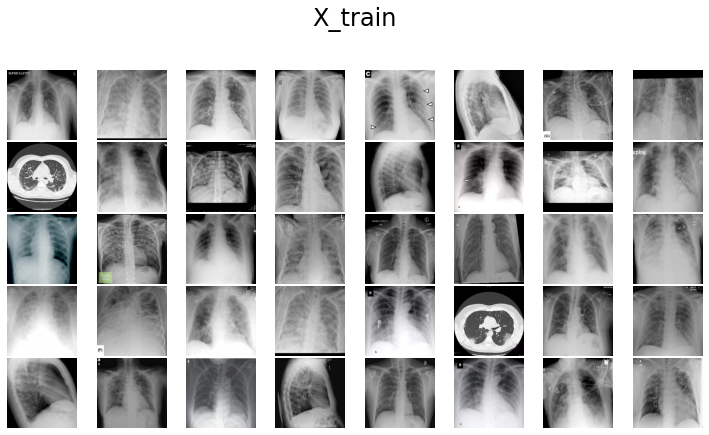

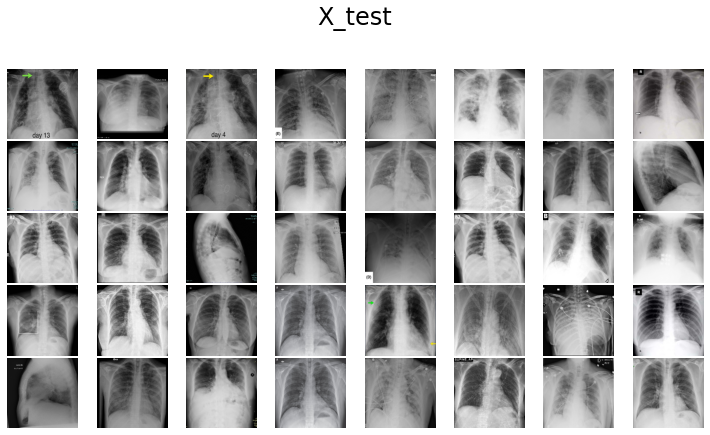

In [7]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')


In [8]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
23/23 [==============================] - 8s 325ms/step - loss: 1.1198 - accuracy: 0.5878 - val_loss: 0.6011 - val_accuracy: 0.6809
Epoch 2/500
23/23 [==============================] - 8s 325ms/step - loss: 0.8678 - accuracy: 0.5957 - val_loss: 0.6391 - val_accuracy: 0.6383
Epoch 3/500
23/23 [==============================] - 8s 326ms/step - loss: 1.6912 - accuracy: 0.5572 - val_loss: 2.9884 - val_accuracy: 0.4628
Epoch 4/500
23/23 [==============================] - 8s 322ms/step - loss: 1.5751 - accuracy: 0.5718 - val_loss: 1.7764 - val_accuracy: 0.5585
Epoch 5/500
23/23 [==============================] - 8s 324ms/step - loss: 1.1895 - accuracy: 0.5612 - val_loss: 0.5607 - val_accuracy: 0.6862
Epoch 6/500
23/23 [==============================] - 8s 322ms/step - loss: 0.9758 - accuracy: 0.6184 - val_loss: 0.8170 - val_accuracy: 0.5957
Epoch 7/500
23/23 [==============================] - 8s 337ms/step - loss: 1.2961 - accuracy: 0.5652 - val_loss: 0.6553 - val_accuracy: 0.6383

In [12]:
model.save('resnet_chest.h5')

C:\Users\Arghyadeep\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [13]:
model.save_weights('resnetweights_chest.hdf5')

In [14]:
model = load_model('resnet_chest.h5')

In [15]:
y_pred = model.predict(X_test, batch_size=batch_size)

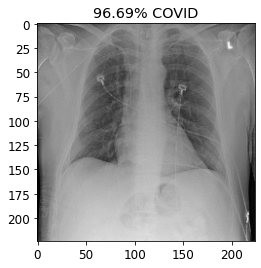

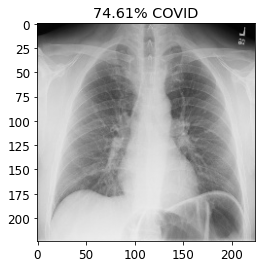

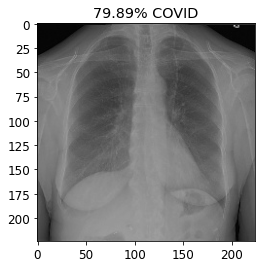

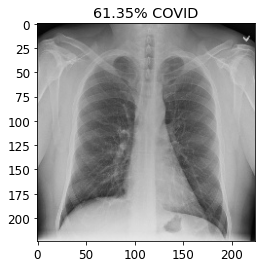

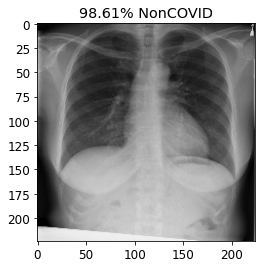

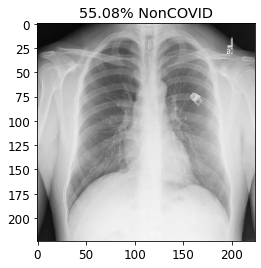

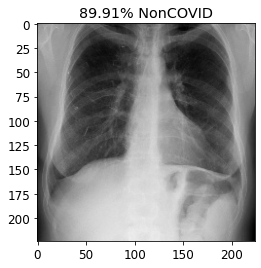

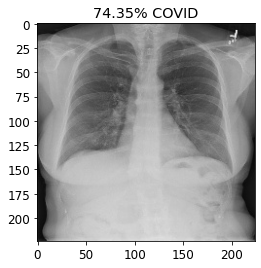

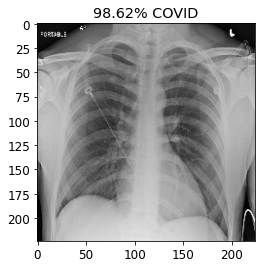

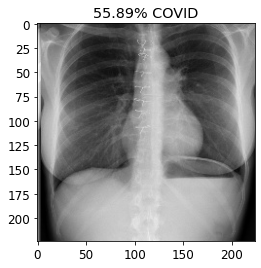

In [39]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% NonCOVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% COVID')
  plt.imshow(X_test[index])
  plt.show()

In [40]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

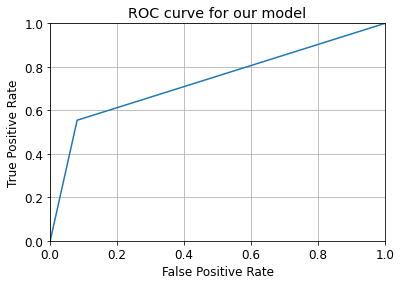

In [41]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


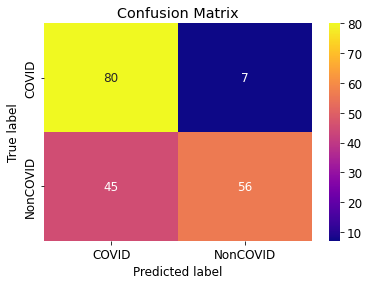

Confusion Matrix with Normalized Values


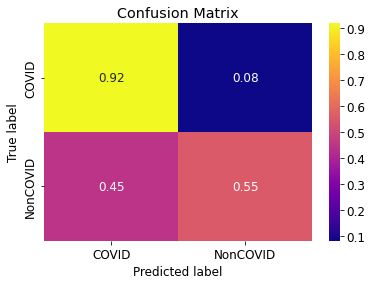

In [42]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.64      0.92      0.75        87
           1       0.89      0.55      0.68       101

    accuracy                           0.72       188
   macro avg       0.76      0.74      0.72       188
weighted avg       0.77      0.72      0.72       188



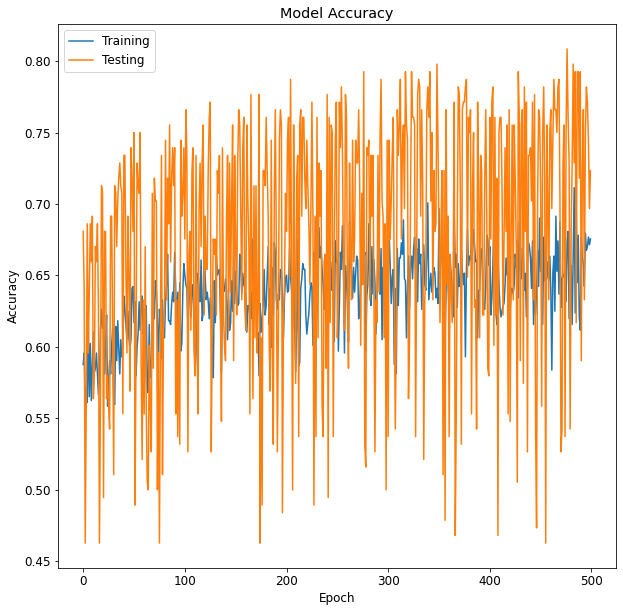

In [44]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()

In [85]:
resnet_chest = load_model('resnet_chest.h5')

In [86]:
image = cv2.imread(r'C:\Users\Arghyadeep\Downloads\Viral Pneumonia-1055.png') 

In [87]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

In [88]:
image = cv2.resize(image,(224,224))

In [89]:
 image = np.array(image) / 255

In [90]:
 image = np.expand_dims(image, axis=0)

In [91]:
resnet_pred = resnet_chest.predict(image)

In [92]:
probability = resnet_pred[0]
print("Resnet Predictions:")
if probability[0] > 0.5:
    resnet_chest_pred = str('%.2f' % (probability[0]*100) + '% NonCOVID') 
else:
    resnet_chest_pred = str('%.2f' % ((1-probability[0])*100) + '% COVID')
print(resnet_chest_pred)

Resnet Predictions:
64.87% COVID
